# HDB Resale Transaction Analysis

###### By: James
---
The focus for this python notebook will be on how to interact with APIs in Python and data pre-processing using Singapore HDB resale data. It will be heavy on the python scripting with brief mention on various ML/statistical model used for regression analysis. Hence, pardon me if there is a lack of academic and statistical rigour in any part of this notebook.

###### Resources
---
HDB resale price: https://data.gov.sg/dataset/resale-flat-prices <br>
HDB resale price index: https://data.gov.sg/dataset/hdb-resale-price-index <br>
HDB property info: https://data.gov.sg/dataset/hdb-property-information <br>
School Information: https://data.gov.sg/dataset/school-directory-and-information <br>
OneMap API: https://www.onemap.gov.sg/docs/#introduction

# Libraries

In [404]:
import glob
import os
import gc
import pandas as pd
import numpy as np
import geopy.distance
import json
import requests

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from collections import Counter

# machine learning
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error

from sklearn.model_selection import KFold, cross_val_score # for cross validation eval, hyperparameter tuning
from sklearn.model_selection import train_test_split 

from sklearn.pipeline import make_pipeline

from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

import lightgbm as lgb

sns.set(style='white', context='notebook', palette='deep')

print ('Panda Version:', pd.__version__)
print ('NumPy Version:', np.__version__)
print ('GeoPy Version:', geopy.__version__)
print ('lightGBM Version:', lgb.__version__)

Panda Version: 1.2.0
NumPy Version: 1.19.2
GeoPy Version: 2.1.0
lightGBM Version: 3.2.1


# Data Preprocessing

## Dataset

A quick check on the data downloaded from data.gov.sg showed that data from 2015 onwards contains 11 columns instead of 10. The additional column is `remaining lease`, which in my opinion will have an impact to HDB resale prices. Keeping that in mind, we will be creating it for data that does not have it.

In [2]:
for files in glob.glob("./data/transaction/*.csv"):
        df = pd.read_csv(files)
        print (files, 'has ', len(df.columns), 'columns\n')
        print (df.columns, '\n')
        print (df.dtypes, '\n')

./data/transaction\resale-flat-prices-based-on-approval-date-1990-1999.csv has  10 columns

Index(['month', 'town', 'flat_type', 'block', 'street_name', 'storey_range',
       'floor_area_sqm', 'flat_model', 'lease_commence_date', 'resale_price'],
      dtype='object') 

month                   object
town                    object
flat_type               object
block                   object
street_name             object
storey_range            object
floor_area_sqm         float64
flat_model              object
lease_commence_date      int64
resale_price             int64
dtype: object 

./data/transaction\resale-flat-prices-based-on-approval-date-2000-feb-2012.csv has  10 columns

Index(['month', 'town', 'flat_type', 'block', 'street_name', 'storey_range',
       'floor_area_sqm', 'flat_model', 'lease_commence_date', 'resale_price'],
      dtype='object') 

month                   object
town                    object
flat_type               object
block                   object
st

Checking if pre-processed dataset is already available, else it will do the necessary merging of dataset

In [3]:
if os.path.exists("./data/transaction/dataset_combined.pkl"):
    df = pd.read_pkl("./data/transaction/dataset_combined.pkl")
else:
    for files in glob.glob("./data/transaction/*.csv"):
        df = pd.read_csv(files)
        print (files, 'has ', len(df.columns), 'columns\n')
        print (df.columns, '\n')
        print (df.dtypes, '\n')
        
    df = pd.DataFrame()
    for files in glob.glob("./data/transaction/*.csv"):
        print ('Concatenating...', files)
        df = pd.concat([df,pd.read_csv(files).iloc[:,:]],axis=0)
    print ('Datasets are now concatenated into one dataframe.')

./data/transaction\resale-flat-prices-based-on-approval-date-1990-1999.csv has  10 columns

Index(['month', 'town', 'flat_type', 'block', 'street_name', 'storey_range',
       'floor_area_sqm', 'flat_model', 'lease_commence_date', 'resale_price'],
      dtype='object') 

month                   object
town                    object
flat_type               object
block                   object
street_name             object
storey_range            object
floor_area_sqm         float64
flat_model              object
lease_commence_date      int64
resale_price             int64
dtype: object 

./data/transaction\resale-flat-prices-based-on-approval-date-2000-feb-2012.csv has  10 columns

Index(['month', 'town', 'flat_type', 'block', 'street_name', 'storey_range',
       'floor_area_sqm', 'flat_model', 'lease_commence_date', 'resale_price'],
      dtype='object') 

month                   object
town                    object
flat_type               object
block                   object
st

In [4]:
df.head(1)

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,remaining_lease
0,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,1977,9000.0,NaN


In [5]:
df.shape

(843541, 11)

In [6]:
df.isnull().sum()

month                       0
town                        0
flat_type                   0
block                       0
street_name                 0
storey_range                0
floor_area_sqm              0
flat_model                  0
lease_commence_date         0
resale_price                0
remaining_lease        709054
dtype: int64

Noticed that we do have many missing data for `remaining_lease`, as such, we will fill the missing value by subtracting `lease_commence_date` from `month` of HDB resale transaction it is recorded to get the remaining lease left. In addition, a typical new HDB leasehold is 99 years, and hence, it will be used in the subtraction to get `remaining lease`.

In [7]:
df['remaining_lease'] = 99 - ((df['month'].apply(lambda x: x.split('-')[0])).astype(int)-df['lease_commence_date'])

Combining the HDB `block` number and `street name` would give us the full address of the HDB unit which will be important for geocoding in the subsequent section

In [8]:
df["full_address"] = df["block"].map(str) + ' ' + df["street_name"].map(str)

In [9]:
df.head(1)

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,remaining_lease,full_address
0,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,1977,9000.0,86,309 ANG MO KIO AVE 1


In [10]:
df['resale_price'].describe()

count    8.435410e+05
mean     2.974412e+05
std      1.514433e+05
min      5.000000e+03
25%      1.830000e+05
50%      2.780000e+05
75%      3.880000e+05
max      1.258000e+06
Name: resale_price, dtype: float64

HDB sold currently are typically more expensive compared to earlier days (1990s), likely due to inflation and possibly supply/demand issues. Thus, normalising the HDB resale price is required to ensure a representative regression model. HDB resale price index would be used in normalising the `resale_price` to reflect present HDB prices (1Q2021)

In [11]:
resale_index = pd.read_csv("./data/resale_index/housing-and-development-board-resale-price-index-1q2009-100-quarterly.csv")

In [12]:
resale_index.dtypes

quarter     object
index      float64
dtype: object

In [13]:
# a function to map year/month into year/quarter for HDB resale price normalisation

def quarter(x):
    year = int(x.split('-')[0])
    month = int(x.split('-')[1])
    if month <= 3:
        month = 'Q1'
    elif month <= 6:
        month = 'Q2'
    elif month <= 9:
        month = 'Q3'
    else:
        month = 'Q3'
    return (str(year) + '-' + str(month))

df['quarter'] = df['month'].apply(quarter)

In [14]:
#Combining  HDB resale price data and HDB resale index
df = pd.merge(df, resale_index, on='quarter')

In [15]:
resale_index.tail(1)

,quarter,index
124,2021-Q1,142.2


Normalising HDB resale price with HDB resale index, making HDB prices sold in the past more representative.

In [16]:
df['resale_price_normalised'] = df['resale_price']*142.2/df['index']

In [17]:
df.head(1)

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,remaining_lease,full_address,quarter,index,resale_price_normalised
0,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,1977,9000.0,86,309 ANG MO KIO AVE 1,1990-Q1,24.3,52666.666667


In [18]:
df['storey_range'].unique()

array(['10 TO 12', '04 TO 06', '07 TO 09', '01 TO 03', '13 TO 15',
       '19 TO 21', '16 TO 18', '25 TO 27', '22 TO 24', '28 TO 30',
       '31 TO 33', '40 TO 42', '37 TO 39', '34 TO 36', '06 TO 10',
       '01 TO 05', '11 TO 15', '16 TO 20', '21 TO 25', '26 TO 30',
       '36 TO 40', '46 TO 48', '43 TO 45', '49 TO 51', '31 TO 35'],
      dtype=object)

Changing `storey_range` into lesser catergorical data of 'low floor', 'mid floor' and 'high floor' and 'very high floor'.
- low floor: 01 to 05
- mid floor: 07 to 10
- high floor: 10 to 20
- very high floor: >=21


In [19]:
df['storey_range'] = df['storey_range'].str.replace('10 TO 12', 'High Floor') \
.str.replace('04 TO 06', 'Low Floor') \
.str.replace('07 TO 09', 'Mid Floor') \
.str.replace('01 TO 03', 'Low Floor') \
.str.replace('13 TO 15', 'High Floor') \
.str.replace('19 TO 21', 'High Floor') \
.str.replace('16 TO 18', 'High Floor') \
.str.replace('25 TO 27', 'Very High Floor') \
.str.replace('22 TO 24', 'Very High Floor') \
.str.replace('28 TO 30', 'Very High Floor') \
.str.replace('31 TO 33', 'Very High Floor') \
.str.replace('31 TO 35', 'Very High Floor') \
.str.replace('40 TO 42', 'Very High Floor') \
.str.replace('37 TO 39', 'Very High Floor') \
.str.replace('34 TO 36', 'Very High Floor') \
.str.replace('06 TO 10', 'Mid Floor') \
.str.replace('01 TO 05', 'Low Floor') \
.str.replace('11 TO 15', 'High Floor') \
.str.replace('16 TO 20', 'High Floor') \
.str.replace('21 TO 25', 'Very High Floor') \
.str.replace('26 TO 30', 'Very High Floor') \
.str.replace('36 TO 40', 'Very High Floor') \
.str.replace('46 TO 48', 'Very High Floor') \
.str.replace('43 TO 45', 'Very High Floor') \
.str.replace('49 TO 51', 'Very High Floor')

In [20]:
df['flat_type'].unique()

array(['1 ROOM', '3 ROOM', '4 ROOM', '5 ROOM', '2 ROOM', 'EXECUTIVE',
       'MULTI GENERATION', 'MULTI-GENERATION'], dtype=object)

In [21]:
df['flat_type'] = df['flat_type'].str.replace('MULTI-GENERATION', 'MULTI GENERATION')

By intuition, `flat model` will play apart in determining the HDB resale price as certain model of flat such as mansionette is rarer than a typical appartment. However, in this analysis, due to a lack of information, this feature will be dropped.

In [22]:
df = df.drop(['flat_model'], axis=1)

In [23]:
df['year'] = df['month'].apply(lambda x: x.split('-')[0])
df['month'] = df['month'].apply(lambda x: x.split('-')[1])

Since HDB sizes are not all the same, it would be crucial for us to compare prices per squared meter of HDB to allow better understanding what are the factors affecting HDB resale prices.

In [24]:
df['price_per_sqm'] = df['resale_price_normalised']/df['floor_area_sqm']

In [25]:
df= df.iloc[:,[-2,0,-5,1,2,3,4,-6,5,6,-1,7,9,-4,8,-3]]

In [26]:
df.head(1)

,year,month,quarter,town,flat_type,block,street_name,full_address,storey_range,floor_area_sqm,price_per_sqm,lease_commence_date,remaining_lease,index,resale_price,resale_price_normalised
0,1990,01,1990-Q1,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,309 ANG MO KIO AVE 1,High Floor,31.0,1698.924731,1977,86,24.3,9000.0,52666.666667


In [29]:
# saving pre-processed data
if os.path.exists("./data/transaction/dataset_combined.pkl"):
    pass
else:
    df.to_pickle(os.path.join("./data/transaction/",r"dataset_combined.pkl"))

## Feature Engineering

Intuitively, HDB nearer to ammenities is more convenient will have fetch will higher price. Thus, we will be exploring HDB distance to nearest school/MRT/CBD area to find out if there is any correlation.

### HDB Address Geocoding

Next, we generate all unique addresses in the dataset for geocoding using OneMap API. Generating the latitude and longitude of each HDB address will allow us to find the distance from HDB to the point of interest we wish to calculate later.

In [30]:
HDB_address_list = df["full_address"].unique().tolist()
len(HDB_address_list)

9381

Simply put, geocoding is converting addresses to longitudes and latitudes.

The script will loop through all addresses in `HDB_address_list` and convert it into a query form. Then it calls the OneMap API. The API provides searching of address data for a given search value. It returns search results with both latitude, longitude and x, y coordinates of the search address.

In [31]:
%%time

HDB_lat = []
HDB_long = []
BLK_NO = []
ROAD_NAME = []
POSTAL_CODE = []
full_address = []

for i in range(0, len(HDB_address_list)):
    query_address = HDB_address_list[i]
    query_string = 'https://developers.onemap.sg/commonapi/search?searchVal='+str(query_address)+'&returnGeom=Y&getAddrDetails=Y'
    resp = requests.get(query_string)

    data_HDB=json.loads(resp.content)
    
    if data_HDB['found'] != 0:
        HDB_lat.append(data_HDB["results"][0]["LATITUDE"])
        HDB_long.append(data_HDB["results"][0]["LONGITUDE"])
        BLK_NO.append(data_HDB["results"][0]["BLK_NO"])
        ROAD_NAME.append(data_HDB["results"][0]["ROAD_NAME"])
        POSTAL_CODE.append(data_HDB["results"][0]["POSTAL"])
        full_address.append(query_address)
        #print (str(query_address) + " ,Lat: " + data_HDB['results'][0]['LATITUDE'] + " Long: " + data_HDB['results'][0]['LONGITUDE'])
    else:
        pass

Wall time: 15min 39s


In [32]:
HDB_location_df = pd.DataFrame({
    'full_address': full_address,
    'Latitude': HDB_lat,
    'Longitude': HDB_long,
    'blk_no': BLK_NO,
    'road_name': ROAD_NAME,
    'postal_code': POSTAL_CODE})

In [33]:
HDB_location_df.head(1)

,full_address,Latitude,Longitude,blk_no,road_name,postal_code
0,216 ANG MO KIO AVE 1,1.36619678831053,103.841505011903,216,ANG MO KIO AVENUE 1,560216


In [34]:
# Concatenate latitude and longitude columns into one column
HDB_location_df["lat_long"] = HDB_location_df["Latitude"] +' '+ HDB_location_df["Longitude"]
# Convert lat_long column to tuples
HDB_location_df["lat_long"] = HDB_location_df["lat_long"].apply(lambda x: tuple(x.split(' ')))

In [224]:
HDB_location_df.shape

(9247, 7)

In [223]:
HDB_location_df = pd.read_pickle("data/HDB_location_df.pkl")

In [222]:
# saving/loading data
if os.path.exists("./data/HDB_location_df.pkl"):
    HDB_location_df = pd.read_pickle("data/HDB_location_df.pkl")
else:
    HDB_location_df.to_pickle(os.path.join("./data/",r"HDB_location_df.pkl"))

### MRT Station Address Geocoding

In order to calculate distance between MRT station to HDB apartment coordinates, geocoding has to be done for MRT station list as well.

In [44]:
# MRT station list is from wikipedia
MRT_station_df = pd.read_csv("./data/mrt/MRT_LRT_STATION.csv")

In [45]:
MRT_station_df.head(1)

,Station
0,Jurong East MRT


In [46]:
MRT_station_list = MRT_station_df["Station"].unique().tolist()
len(MRT_station_list)

160

In [47]:
%%time

mrt_lat = []
mrt_long = []
MRT_station = []

for i in range(0, len(MRT_station_list)):
    query_address = MRT_station_list[i]
    query_string = 'https://developers.onemap.sg/commonapi/search?searchVal='+str(query_address)+'&returnGeom=Y&getAddrDetails=Y'
    resp = requests.get(query_string)

    data_mrt=json.loads(resp.content)
    
    if data_mrt['found'] != 0:
        mrt_lat.append(data_mrt["results"][0]["LATITUDE"])
        mrt_long.append(data_mrt["results"][0]["LONGITUDE"])
        MRT_station.append(query_address)

        # print (str(query_address)+",Lat: "+data_mrt['results'][0]['LATITUDE'] +" Long: "+data_mrt['results'][0]['LONGITUDE'])

    else:
        pass

Wall time: 26.1 s


In [48]:
MRT_location_df = pd.DataFrame({
    'MRT': MRT_station,
    'Latitude': mrt_lat,
    'Longitude': mrt_long})

In [49]:
MRT_location_df.head(1)

,MRT,Latitude,Longitude
0,Jurong East MRT,1.33357652289465,103.742292350324


In [50]:
# Concatenate latitude and longitude columns into one column
MRT_location_df["lat_long"] = MRT_location_df["Latitude"] +' '+ MRT_location_df["Longitude"]
# Convert lat_long column to tuples
MRT_location_df["lat_long"] = MRT_location_df["lat_long"].apply(lambda x: tuple(x.split(' ')))

In [51]:
MRT_location_df.shape

(159, 4)

In [52]:
MRT_location_df.head(1)

,MRT,Latitude,Longitude,lat_long
0,Jurong East MRT,1.33357652289465,103.742292350324,"(1.33357652289465, 103.742292350324)"


In [53]:
# saving/loading data
if os.path.exists("./data/MRT_location_df.pkl"):
    MRT_location_df = pd.read_pickle("./data/MRT_location_df.pkl")
else:
    MRT_location_df.to_pickle(os.path.join("./data/",r"MRT_location_df.pkl"))

In [54]:
MRT_location_df.reset_index()

# convert the lat_long column in station_latlong_df to a list
MRT_location_list = list(MRT_location_df.T.iloc[-1,:])

In [55]:
MRT_location_list[0:3]

[('1.33357652289465', '103.742292350324'),
 ('1.34842377665437', '103.749126361849'),
 ('1.35930937732431', '103.751948590322')]

Now that we have the coordinates for MRT stations, we will need to calculate the distance between nearest MRT station to the HDB appartment.

Distance between two points can be calculated using geodesics formula or great circle formula. For ease of computational time, great circle computation will be used. Both formulae are implemented in GeoPy package. 

As I am no mathematician, you can check out more info on the formulae in the link given below

Great Circle: https://en.wikipedia.org/wiki/Great-circle_distance <br>
Geodesics: https://en.wikipedia.org/wiki/Geodesics_on_an_ellipsoid <br>
GeoPy: https://geopy.readthedocs.io/en/stable/#module-geopy.distance


In [56]:
%%time
MRT_dist_df = pd.DataFrame(HDB_location_df["lat_long"])
for x in MRT_location_list:
    MRT_dist_df[x]=HDB_location_df['lat_long'].apply(lambda y: geopy.distance.great_circle(y, x).km)

Wall time: 17 s


In [57]:
MRT_dist_df.shape

(9247, 160)

In [58]:
MRT_dist_df.head(1)

,lat_long,"(1.33357652289465, 103.742292350324)","(1.34842377665437, 103.749126361849)","(1.35930937732431, 103.751948590322)","(1.38575650064861, 103.744509334035)","(1.39753506936297, 103.747405150236)","(1.42513172976083, 103.762492227566)","(1.43275722977074, 103.773981720213)","(1.43659643136072, 103.78584424633)","(1.44053338763298, 103.801364534318)",...,"(1.39451978540249, 103.916169381157)","(1.39950910636258, 103.916574974234)","(1.40228667971123, 103.912727352412)","(1.40523483636956, 103.908603542566)","(1.40961268528803, 103.904831550608)","(1.41684852031206, 103.906650789313)","(1.41590172160383, 103.902156317163)","(1.41187040942086, 103.900313788123)","(1.40845241943076, 103.898558450395)","(1.40532331860455, 103.897290522033)"
0,"(1.36619678831053, 103.841505011903)",11.610051,10.457604,9.984831,10.999503,11.025553,10.958581,10.541251,9.978095,9.393333,...,8.877328,9.130144,8.876225,8.63002,8.535871,9.174145,8.718002,8.278263,7.893069,7.575224


In [59]:
# get the distance from each address to the nearest station
MRT_dist_df['distance_to_nearest_station'] = MRT_dist_df.iloc[:,1:].apply(lambda x: min(x), axis=1)

In [60]:
MRT_dist_df = MRT_dist_df.iloc[:,[0,-1]]
MRT_dist_df.head(1)

,lat_long,distance_to_nearest_station
0,"(1.36619678831053, 103.841505011903)",1.011905


In [62]:
# saving/loading data
if os.path.exists("./data/MRT_dist_df.pkl"):
    MRT_dist_df = pd.read_pickle("data/MRT_dist_df.pkl")
else:
    MRT_dist_df.to_pickle(os.path.join("./data/",r"MRT_dist_df.pkl"))

In [64]:
# Merging MRT distance into HDB dataframe
HDB_MRT_combined_df = pd.merge(HDB_location_df, MRT_dist_df, on='lat_long', how='left')

In [65]:
HDB_MRT_combined_df.head(1)

,full_address,Latitude,Longitude,blk_no,road_name,postal_code,lat_long,distance_to_nearest_station
0,216 ANG MO KIO AVE 1,1.36619678831053,103.841505011903,216,ANG MO KIO AVENUE 1,560216,"(1.36619678831053, 103.841505011903)",1.011905


### School Address Geocoding

Similar to what was done to MRT geocoding, school address geocoding will have to be done to calculate the distance between the HDB apartment to the nearest school

In [66]:
school_address_df = pd.read_csv("data/school/general-information-of-schools.csv")

In [67]:
school_address_df.head(1)

,school_name,url_address,address,postal_code,telephone_no,telephone_no_2,fax_no,fax_no_2,email_address,mrt_desc,...,nature_code,session_code,mainlevel_code,sap_ind,autonomous_ind,gifted_ind,ip_ind,mothertongue1_code,mothertongue2_code,mothertongue3_code
0,ADMIRALTY PRIMARY SCHOOL,https://admiraltypri.moe.edu.sg/,11 WOODLANDS CIRCLE,738907,63620598,na,63627512,na,ADMIRALTY_PS@MOE.EDU.SG,Admiralty Station,...,CO-ED SCHOOL,FULL DAY,PRIMARY,No,No,No,No,Chinese,Malay,Tamil


In [68]:
school_address_list = school_address_df["address"].unique().tolist()
len(school_address_list)

345

In [69]:
%%time

sch_lat = []
sch_long = []
sch_address = []

for i in range(0, len(school_address_list)):
    query_address = school_address_list[i]
    query_string = 'https://developers.onemap.sg/commonapi/search?searchVal='+str(query_address)+'&returnGeom=Y&getAddrDetails=Y'
    resp = requests.get(query_string)

    data_school=json.loads(resp.content)
    
    if data_school['found'] != 0:
        sch_lat.append(data_school["results"][0]["LATITUDE"])
        sch_long.append(data_school["results"][0]["LONGITUDE"])
        sch_address.append(query_address)

        #print (str(query_address)+",Lat: "+data_school['results'][0]['LATITUDE'] +" Long: "+data_school['results'][0]['LONGITUDE'])

    else:
        pass

Wall time: 31.5 s


In [82]:
school_location_df = pd.DataFrame({
    'School': sch_address,
    'Latitude': sch_lat,
    'Longitude': sch_long})

In [83]:
school_location_df.shape

(344, 3)

In [84]:
# Concatenate latitude and longitude columns into one column
school_location_df["lat_long"] = school_location_df["Latitude"] +' '+ school_location_df["Longitude"]
# Convert lat_long column to tuples
school_location_df["lat_long"] = school_location_df["lat_long"].apply(lambda x: tuple(x.split(' ')))

In [85]:
MRT_location_df.shape

(159, 4)

In [86]:
MRT_location_df.head(1)

,MRT,Latitude,Longitude,lat_long
0,Jurong East MRT,1.33357652289465,103.742292350324,"(1.33357652289465, 103.742292350324)"


In [87]:
# saving/loading data
if os.path.exists("./data/school_location_df.pkl"):
    school_location_df = pd.read_pickle("data/school_location_df.pkl")
else:
    school_location_df.to_pickle(os.path.join("./data/",r"school_location_df.pkl"))

In [91]:
school_location_df.reset_index()

# convert the lat_long column in station_latlong_df to a list
school_location_list = list(school_location_df.T.iloc[-1,:])

In [92]:
school_location_list[0:3]

[('1.44267961678131', '103.800114351557'),
 ('1.44589068910991', '103.802398196596'),
 ('1.43368120674913', '103.832924289687')]

In [93]:
%%time
school_dist_df = pd.DataFrame(HDB_location_df["lat_long"])
for x in school_location_list:
    school_dist_df[x] = HDB_location_df['lat_long'].apply(lambda y: geopy.distance.great_circle(y, x).km)

Wall time: 35.7 s


In [94]:
# get the distance from each address to the nearest school
school_dist_df['distance_to_nearest_sch'] = school_dist_df.iloc[:,1:].apply(lambda x: min(x), axis=1)

In [95]:
school_dist_df = school_dist_df.iloc[:,[0,-1]]
school_dist_df.head(1)

,lat_long,distance_to_nearest_sch
0,"(1.36619678831053, 103.841505011903)",0.17756


In [96]:
# saving/loading data
if os.path.exists("./data/school_dist_df.pkl"):
    school_dist_df = pd.read_pickle("data/school_dist_df.pkl")
else:
    school_dist_df.to_pickle(os.path.join("./data/",r"school_dist_df.pkl"))

In [97]:
# Merging school distance into HDB dataframe together with MRT distance
HDB_MRT_SCH_combined_df = pd.merge(HDB_MRT_combined_df, school_dist_df, on='lat_long', how='left')

In [98]:
HDB_MRT_SCH_combined_df.head(1)

,full_address,Latitude,Longitude,blk_no,road_name,postal_code,lat_long,distance_to_nearest_station,distance_to_nearest_sch
0,216 ANG MO KIO AVE 1,1.36619678831053,103.841505011903,216,ANG MO KIO AVENUE 1,560216,"(1.36619678831053, 103.841505011903)",1.011905,0.17756


In [99]:
HDB_MRT_SCH_combined_df.dtypes

full_address                    object
Latitude                        object
Longitude                       object
blk_no                          object
road_name                       object
postal_code                     object
lat_long                        object
distance_to_nearest_station    float64
distance_to_nearest_sch        float64
dtype: object

In [103]:
# saving/loading data
if os.path.exists("./data/HDB_MRT_SCH_combined_df.pkl"):
    HDB_MRT_SCH_combined_df = pd.read_pickle("data/HDB_MRT_SCH_combined_df.pkl")
else:
    HDB_MRT_SCH_combined_df.to_pickle(os.path.join("./data/",r"HDB_MRT_SCH_combined_df.pkl"))

### CBD Address Geocoding

In [107]:
%%time

# City Hall: 1.2931° N, 103.8521° E

HDB_MRT_SCH_combined_df['distance_to_city'] = HDB_MRT_SCH_combined_df['lat_long'].apply(lambda y: geopy.distance.great_circle((1.2931, 103.8521), y).km)

Wall time: 127 ms


In [ ]:
HDB_MRT_SCH_City_combined_df = HDB_MRT_SCH_combined_df

In [115]:
# saving/loading data
if os.path.exists("./data/HDB_MRT_SCH_City_combined_df.pkl"):
    HDB_MRT_SCH_City_combined_df = pd.read_pickle("data/HDB_MRT_SCH_City_combined_df.pkl")
else:
    HDB_MRT_SCH_City_combined_df.to_pickle(os.path.join("./data/",r"HDB_MRT_SCH_City_combined_df.pkl"))

In [116]:
HDB_MRT_SCH_City_combined_df.dtypes

full_address                    object
Latitude                        object
Longitude                       object
blk_no                          object
road_name                       object
postal_code                     object
lat_long                        object
distance_to_nearest_station    float64
distance_to_nearest_sch        float64
distance_to_city               float64
dtype: object

### Additional HDB Info

As I am intending to make a dashboard using Tableau, would think such additional information. Hence, I've included in the data-preprocessing step. Do note that this features are probably useless for regression analysis.

In [117]:
hdb_extra_info_df = pd.read_csv("data/hdb_extra_info/hdb-property-information.csv")

In [119]:
hdb_extra_info_df.head(1)

,blk_no,street,max_floor_lvl,year_completed,residential,commercial,market_hawker,miscellaneous,multistorey_carpark,precinct_pavilion,...,3room_sold,4room_sold,5room_sold,exec_sold,multigen_sold,studio_apartment_sold,1room_rental,2room_rental,3room_rental,other_room_rental
0,1,BEACH RD,16,1970,Y,Y,N,N,N,N,...,138,1,2,0,0,0,0,0,0,0


In [120]:
hdb_extra_info_df.dtypes

blk_no                   object
street                   object
max_floor_lvl             int64
year_completed            int64
residential              object
commercial               object
market_hawker            object
miscellaneous            object
multistorey_carpark      object
precinct_pavilion        object
bldg_contract_town       object
total_dwelling_units      int64
1room_sold                int64
2room_sold                int64
3room_sold                int64
4room_sold                int64
5room_sold                int64
exec_sold                 int64
multigen_sold             int64
studio_apartment_sold     int64
1room_rental              int64
2room_rental              int64
3room_rental              int64
other_room_rental         int64
dtype: object

In [122]:
hdb_extra_info_df['full_address'] = hdb_extra_info_df["blk_no"].map(str) + ' ' + hdb_extra_info_df["street"].map(str)

In [124]:
# Filter out instances that are not commercial buildings
hdb_extra_info_df = hdb_extra_info_df[hdb_extra_info_df["commercial"]=='N']

# Select columns that may be useful in modeling
hdb_extra_info_df = hdb_extra_info_df.iloc[:,[-1,2,3,4,6,7,8,9]]

In [125]:
len(hdb_extra_info_df)

9840

In [127]:
hdb_extra_info_df.head(1)

,full_address,max_floor_lvl,year_completed,residential,market_hawker,miscellaneous,multistorey_carpark,precinct_pavilion
1,1 BEDOK STH AVE 1,14,1975,Y,N,Y,N,N


In [128]:
# saving/loading data
if os.path.exists("./data/hdb_extra_info_df.pkl"):
    hdb_extra_info_df = pd.read_pickle("data/hdb_extra_info_df.pkl")
else:
    hdb_extra_info_df.to_pickle(os.path.join("./data/",r"hdb_extra_info_df.pkl"))

### Merging of engineered feature with original dataset

We will be merging "df", "HDB_MRT_SCH_City_combined_df" and "hdb_extra_info_df" together based on `full_address` column. Thus, it is important for us to check for any abbreviation used in the various dataframe in order for dataframe to merge smoothly.

In [130]:
HDB_MRT_SCH_City_combined_df['full_address'] = HDB_MRT_SCH_City_combined_df['full_address'].str.replace('AVENUE', 'AVE') \
                                    .str.replace('CRESCENT', 'CRES') \
                                    .str.replace('ROAD', 'RD') \
                                    .str.replace('STREET', 'ST') \
                                    .str.replace('CENTRAL', 'CTRL') \
                                    .str.replace('HEIGHTS', 'HTS') \
                                    .str.replace('TERRACE', 'TER') \
                                    .str.replace('JALAN', 'JLN') \
                                    .str.replace('DRIVE', 'DR') \
                                    .str.replace('PLACE', 'PL') \
                                    .str.replace('CLOSE', 'CL') \
                                    .str.replace('PARK', 'PK') \
                                    .str.replace('GARDENS', 'GDNS') \
                                    .str.replace('NORTH', 'NTH') \
                                    .str.replace('SOUTH', 'STH') \
                                    .str.replace('BUKIT', 'BT') \
                                    .str.replace('UPPER', 'UPP}') \
                                    .str.replace('COMMONWEALTH', "C'WEALTH")

In [137]:
len(HDB_MRT_SCH_City_combined_df)

9271

In [138]:
HDB_MRT_SCH_City_combined_df_processed = HDB_MRT_SCH_City_combined_df.drop_duplicates('full_address')

In [139]:
len(HDB_MRT_SCH_City_combined_df_processed)

9247

In [177]:
HDB_data_processed = pd.merge(df, HDB_MRT_SCH_City_combined_df_processed, on='full_address', how='left')

In [178]:
HDB_data_processed = pd.merge(HDB_data_processed, hdb_extra_info_df, on='full_address', how='left')

In [179]:
HDB_data_processed.head(1)

,year,month,quarter,town,flat_type,block,street_name,full_address,storey_range,floor_area_sqm,...,distance_to_nearest_station,distance_to_nearest_sch,distance_to_city,max_floor_lvl,year_completed,residential,market_hawker,miscellaneous,multistorey_carpark,precinct_pavilion
0,1990,01,1990-Q1,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,309 ANG MO KIO AVE 1,High Floor,31.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [180]:
HDB_data_processed.isnull().sum()

year                                0
month                               0
quarter                             0
town                                0
flat_type                           0
block                               0
street_name                         0
full_address                        0
storey_range                        0
floor_area_sqm                      0
price_per_sqm                       0
lease_commence_date                 0
remaining_lease                     0
index                               0
resale_price                        0
resale_price_normalised             0
Latitude                        12196
Longitude                       12196
blk_no                          12196
road_name                       12196
postal_code                     12196
lat_long                        12196
distance_to_nearest_station     12196
distance_to_nearest_sch         12196
distance_to_city                12196
max_floor_lvl                  201317
year_complet

Noticed that the important value that will be used for regression contains only 1.5% of missing data out of entire dataset, this is probably okay and wouldnt affect the regression analysis. Thus, we will be dropping the data with missing info

In [181]:
12196/len(HDB_data_processed)*100

1.4503404661163077

In [190]:
#dropping missing values
HDB_data_processed = HDB_data_processed.dropna(subset=['lat_long'])

In [191]:
HDB_data_processed.head()

,year,month,quarter,town,flat_type,block,street_name,full_address,storey_range,floor_area_sqm,...,distance_to_nearest_station,distance_to_nearest_sch,distance_to_city,max_floor_lvl,year_completed,residential,market_hawker,miscellaneous,multistorey_carpark,precinct_pavilion
4,1990,01,1990-Q1,ANG MO KIO,3 ROOM,216,ANG MO KIO AVE 1,216 ANG MO KIO AVE 1,Low Floor,73.0,...,1.011905,0.177560,8.212895,10.0,1975.0,Y,N,N,N,N
5,1990,01,1990-Q1,ANG MO KIO,3 ROOM,211,ANG MO KIO AVE 3,211 ANG MO KIO AVE 3,Low Floor,67.0,...,0.910232,0.229220,8.540727,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,1990,01,1990-Q1,ANG MO KIO,3 ROOM,202,ANG MO KIO AVE 3,202 ANG MO KIO AVE 3,Mid Floor,67.0,...,0.611354,0.245430,8.421699,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,1990,01,1990-Q1,ANG MO KIO,3 ROOM,235,ANG MO KIO AVE 3,235 ANG MO KIO AVE 3,High Floor,67.0,...,1.520949,0.204981,8.379324,12.0,1976.0,Y,N,Y,N,N
8,1990,01,1990-Q1,ANG MO KIO,3 ROOM,235,ANG MO KIO AVE 3,235 ANG MO KIO AVE 3,Low Floor,67.0,...,1.520949,0.204981,8.379324,12.0,1976.0,Y,N,Y,N,N


In [184]:
# saving/loading data
if os.path.exists("./data/HDB_data_processed.pkl"):
    HDB_data_processed = pd.read_pickle("data/HDB_data_processed.pkl")
else:
    HDB_data_processed.to_pickle(os.path.join("./data/",r"HDB_data_processed.pkl"))

# ML Modelling

After finishing with data pre-processing, we are ready for creating a model for predicting HDB resale prices. As the prediction is of continous basis, estimator to be used will be regression model.

In [194]:
HDB_data_processed.columns

Index(['year', 'month', 'quarter', 'town', 'flat_type', 'block', 'street_name',
       'full_address', 'storey_range', 'floor_area_sqm', 'price_per_sqm',
       'lease_commence_date', 'remaining_lease', 'index', 'resale_price',
       'resale_price_normalised', 'Latitude', 'Longitude', 'blk_no',
       'road_name', 'postal_code', 'lat_long', 'distance_to_nearest_station',
       'distance_to_nearest_sch', 'distance_to_city', 'max_floor_lvl',
       'year_completed', 'residential', 'market_hawker', 'miscellaneous',
       'multistorey_carpark', 'precinct_pavilion'],
      dtype='object')

In [209]:
chosen_feats_list = ['town', 
                     'flat_type', 
                     'storey_range', 
                     'floor_area_sqm',
                     'price_per_sqm', 
                     'remaining_lease',  
                     'distance_to_nearest_station', 
                     'distance_to_nearest_sch', 
                     'distance_to_city']

In [284]:
data_choosen = HDB_data_processed[chosen_feats_list]

In [285]:
data_choosen.head()

,town,flat_type,storey_range,floor_area_sqm,price_per_sqm,remaining_lease,distance_to_nearest_station,distance_to_nearest_sch,distance_to_city
4,ANG MO KIO,3 ROOM,Low Floor,73.0,3783.663115,85,1.011905,0.177560,8.212895
5,ANG MO KIO,3 ROOM,Low Floor,67.0,4017.689331,86,0.910232,0.229220,8.540727
6,ANG MO KIO,3 ROOM,Mid Floor,67.0,3668.325041,86,0.611354,0.245430,8.421699
7,ANG MO KIO,3 ROOM,High Floor,67.0,3318.960752,86,1.520949,0.204981,8.379324
8,ANG MO KIO,3 ROOM,Low Floor,67.0,3493.642897,86,1.520949,0.204981,8.379324


In [286]:
# convert to indicator values Title and Embarked 
data_choosen = pd.get_dummies(data_choosen)

In [287]:
data_choosen.columns

Index(['floor_area_sqm', 'price_per_sqm', 'remaining_lease',
       'distance_to_nearest_station', 'distance_to_nearest_sch',
       'distance_to_city', 'town_ANG MO KIO', 'town_BEDOK', 'town_BISHAN',
       'town_BUKIT BATOK', 'town_BUKIT MERAH', 'town_BUKIT PANJANG',
       'town_BUKIT TIMAH', 'town_CENTRAL AREA', 'town_CHOA CHU KANG',
       'town_CLEMENTI', 'town_GEYLANG', 'town_HOUGANG', 'town_JURONG EAST',
       'town_JURONG WEST', 'town_KALLANG/WHAMPOA', 'town_LIM CHU KANG',
       'town_MARINE PARADE', 'town_PASIR RIS', 'town_PUNGGOL',
       'town_QUEENSTOWN', 'town_SEMBAWANG', 'town_SENGKANG', 'town_SERANGOON',
       'town_TAMPINES', 'town_TOA PAYOH', 'town_WOODLANDS', 'town_YISHUN',
       'flat_type_1 ROOM', 'flat_type_2 ROOM', 'flat_type_3 ROOM',
       'flat_type_4 ROOM', 'flat_type_5 ROOM', 'flat_type_EXECUTIVE',
       'flat_type_MULTI GENERATION', 'storey_range_High Floor',
       'storey_range_Low Floor', 'storey_range_Mid Floor',
       'storey_range_Very High Floo

In the heat map below, it is evident that `floor_area_sqm` and `distance_to_city` does affect the `price_per_sqm`. While `remaining_lease`, `distance_to_nearest_station` and `distance_to_nearest_sch` have a lesser effect on the `price_per_sqm` of HDB apartment sold.

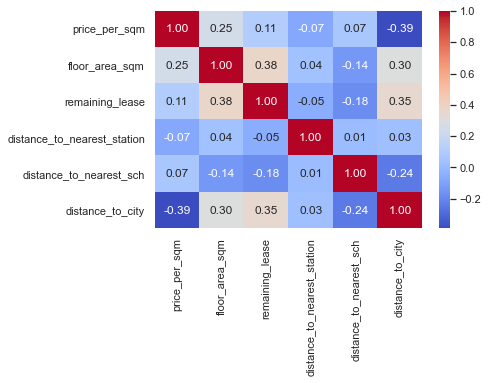

In [288]:
continuous_features = ['price_per_sqm', 'floor_area_sqm' ,'remaining_lease',
       'distance_to_nearest_station',
       'distance_to_nearest_sch', 'distance_to_city']
g = sns.heatmap(data_choosen[continuous_features].corr(),annot=True, fmt = ".2f", cmap = "coolwarm")

Now, we will split the data in chronological order in a 80/20 split.

In [230]:
"""
train = model_data[:round(0.8*len(df_model))]
test = model_data[round(0.8*len(df_model)):]

X_train = train.drop('price_per_sqm', axis=1)
X_test = test.drop('price_per_sqm', axis=1)

y_train = train['price_per_sqm']
y_test = test['price_per_sqm']
"""

In [289]:
model_data = data_choosen.copy()

In [290]:
X = model_data.drop('price_per_sqm', axis=1)
y = model_data['price_per_sqm']

In [291]:
print('Average price_per_sqm:', y.mean())
print('Min price_per_sqm:', y.min())
print('Max price_per_sqm:', y.max())

Average price_per_sqm: 4769.712320127288
Min price_per_sqm: 865.4899573950091
Max price_per_sqm: 13758.832742302331


In [292]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

### Lasso Regression

In [245]:
%%time
model_lasso = make_pipeline(StandardScaler(),Lasso(max_iter=100000, random_state=1))
model_lasso.fit(X_train, y_train)  # apply scaling on training data
model_lasso.score(X_test, y_test)

Wall time: 17.3 s


0.4648234181900269

R-Squared (score of the model) — this percentage is the explained variance of the predictions. Our model can explain only about 0.465 or 46.5% of the variance in our data. Hence, Lasso regression does not seem to be a good model of choice for predicting the `price_per_sqm` for HDB resale transaction.

In [246]:
print('Mean Absolute Error:', mean_absolute_error(y_test, model_lasso.predict(X_test)))  
print('Mean Squared Error:', mean_squared_error(y_test, model_lasso.predict(X_test)))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, model_lasso.predict(X_test))))

Mean Absolute Error: 563.1581015019303
Mean Squared Error: 575635.1718189536
Root Mean Squared Error: 758.7062487016656


Mean Abosulte Error gives us the average absolute value of our actual data from the model’s prediction. Our MAE is fairly small compared to the range and mean of price per sqm in our data set.

However, from RMSE value, the model’s prediction will miss the actual value of the property by $758.71 on average. If we take our RMSE as a percentage of our mean price per sqm, it will give us a 16% of error rate. This is fairly high and not further emphasis that the model is not a good choice.

### Decision Tree Regression

In [247]:
%%time
model_DT = make_pipeline(StandardScaler(),DecisionTreeRegressor(max_depth=40))
model_DT.fit(X_train, y_train)
model_DT.score(X_test, y_test)

Wall time: 13 s


0.7893384746169623

R-Squared (score of the model) — this percentage is the explained variance of the predictions. Our model can explain about 0.789 or 78.9% of the variance in our data. This is a significant improvement compared to Lasso Regression Model. Thus, let's explore using ensemble learning method to further improve the prediction.

In [248]:
print('Mean Absolute Error:', mean_absolute_error(y_test, model_DT.predict(X_test)))  
print('Mean Squared Error:', mean_squared_error(y_test, model_DT.predict(X_test)))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, model_DT.predict(X_test))))

Mean Absolute Error: 323.706874983798
Mean Squared Error: 226587.23771019833
Root Mean Squared Error: 476.0118041710713


From RMSE value, the model’s prediction will miss the actual value of the property by $476 on average. If we take our RMSE as a percentage of our mean price per sqm, it will give us a 10% of error rate. This is still high. Let's see if ensemble learning method could reduce the error rate to single digit.

In [249]:
feature_importances = pd.DataFrame(model_DT.steps[1][1].feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)

In [250]:
feature_importances

,importance
distance_to_city,0.282319
remaining_lease,0.219464
floor_area_sqm,0.213123
distance_to_nearest_station,0.064317
distance_to_nearest_sch,0.038069
flat_type_3 ROOM,0.020596
storey_range_Very High Floor,0.018182
storey_range_Low Floor,0.012449
town_CLEMENTI,0.011892
town_QUEENSTOWN,0.010657


### Random Forest Regression

In [251]:
%%time
model_RFR = make_pipeline(StandardScaler(),RandomForestRegressor(random_state=1))
model_RFR.fit(X_train, y_train)  # apply scaling on training data
model_RFR.score(X_test, y_test)

Wall time: 13min 43s


0.8585493709357035

R-Squared (score of the model) — this percentage is the explained variance of the predictions. Our model can explain about 0.859 or 85.9% of the variance in our data. Again, ensemble method indeed helps to improve the model prediction capability.

In [252]:
print('Mean Absolute Error:', mean_absolute_error(y_test, model_RFR.predict(X_test)))  
print('Mean Squared Error:', mean_squared_error(y_test, model_RFR.predict(X_test)))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, model_RFR.predict(X_test))))

Mean Absolute Error: 267.9025988140442
Mean Squared Error: 152144.09586075062
Root Mean Squared Error: 390.0565290579695


From RMSE value, the model’s prediction will miss the actual value of the property by $390 on average. This bring our error rate to approximately 8%. This is a significant improvement as compared to our very initial model.

In [253]:
feature_importances = pd.DataFrame(model_RFR.steps[1][1].feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)

In [254]:
feature_importances

,importance
distance_to_city,0.278786
remaining_lease,0.219799
floor_area_sqm,0.210328
distance_to_nearest_station,0.068235
distance_to_nearest_sch,0.043116
flat_type_3 ROOM,0.020884
storey_range_Very High Floor,0.018493
storey_range_Low Floor,0.012666
town_CLEMENTI,0.011947
town_QUEENSTOWN,0.009202


## Improving Baseline Model

While the ensemble method of using random forest regression reduce prediction error rate to 8%, I believe there is further room for improvement.

Remember that we did normalisation of HDB resale prices to 1Q2021 based on resale index provided by data.gov? This would still not account accurately for other variables like improve amenities over the years. In addition, the resale index does not account for individual district but rather, all the HDB transaction as a hold. Thus, if we are going to use data closer to 2021, we may be able to yield better results.

As such, in the following, we will be taking data from 2016 onwards for prediction to see if there is any improvement to the models. On a side note, it will also reduces the time complexity of the model due to lesser data.

In [ ]:
#HDB_data_processed['flat_type'].value_counts()

In [294]:
data_choosen['year'] = HDB_data_processed['year']

In [309]:
data = data_choosen.loc[(HDB_data_processed['year'].astype(int) >=2016)]
# = data_choosen.loc[(HDB_data_processed['year'].astype(int) >=2021)]

In [310]:
X_ = data.drop(['price_per_sqm','year'], axis=1)
y_ = data['price_per_sqm']

In [313]:
X_train_, X_test_, y_train_, y_test_ = train_test_split(X_, y_, test_size=0.2, random_state=1)

### Lasso Regression

In [315]:
%%time
model_lasso_ = make_pipeline(StandardScaler(),Lasso(max_iter=1000000, random_state=1))
model_lasso_.fit(X_train_, y_train_)  # apply scaling on training data
model_lasso_.score(X_test_, y_test_)

Wall time: 1.32 s


0.7956972246859556

In [316]:
print('Mean Absolute Error:', mean_absolute_error(y_test_, model_lasso_.predict(X_test_)))  
print('Mean Squared Error:', mean_squared_error(y_test_, model_lasso_.predict(X_test_)))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test_, model_lasso_.predict(X_test_))))

Mean Absolute Error: 439.6498572432081
Mean Squared Error: 343441.40387233
Root Mean Squared Error: 586.0387392249168


Evidently, the improvement in model score improved by approximately 25%. Similarly, RMSE has dropped from $758 to $586. This showed understanding the dataset will allow better model prediction capability. 

### Decision Tree Regression

In [317]:
%%time
model_DT_ = make_pipeline(StandardScaler(),DecisionTreeRegressor(max_depth=40))
model_DT_.fit(X_train_, y_train_)
model_DT_.score(X_test_, y_test_)

Wall time: 1.61 s


0.9166268137262923

In [318]:
print('Mean Absolute Error:', mean_absolute_error(y_test_, model_DT_.predict(X_test_)))  
print('Mean Squared Error:', mean_squared_error(y_test_, model_DT_.predict(X_test_)))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test_, model_DT_.predict(X_test_))))

Mean Absolute Error: 267.16951125096455
Mean Squared Error: 140153.7697916093
Root Mean Squared Error: 374.3711658122314


### Random Forest Regression

In [319]:
%%time
model_RFR_ = make_pipeline(StandardScaler(),RandomForestRegressor(random_state=1))
model_RFR_.fit(X_train_, y_train_)  # apply scaling on training data
model_RFR_.score(X_test_, y_test_)

Wall time: 1min 36s


0.946744925197173

In [320]:
print('Mean Absolute Error:', mean_absolute_error(y_test_, model_RFR_.predict(X_test_)))  
print('Mean Squared Error:', mean_squared_error(y_test_, model_RFR_.predict(X_test_)))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test_, model_RFR_.predict(X_test_))))

Mean Absolute Error: 216.45336728950912
Mean Squared Error: 89523.98040356692
Root Mean Squared Error: 299.2055821731388


In [321]:
feature_importances__ = pd.DataFrame(model_RFR_.steps[1][1].feature_importances_,
                                   index = X_train_.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)

In [322]:
feature_importances__

,importance
distance_to_city,0.418590
remaining_lease,0.366870
distance_to_nearest_station,0.047400
floor_area_sqm,0.037821
distance_to_nearest_sch,0.022545
storey_range_Low Floor,0.016835
town_TAMPINES,0.011138
storey_range_Very High Floor,0.009803
town_BUKIT TIMAH,0.006664
town_HOUGANG,0.006581


From the 3 regression model we tested, it is clear that ensemble method helps to improve model prediction capability as long as every single estimator in ensemble learning is capable of prediction better than random guessing. Thus, in most ML algorithm, ensemble methods are preferred.

Also, note that, no hyper-parameters tuning was done in this exercise. Performance would probably improve with hyper-parameter tuning and lastly, k-fold cross validation would be a better way of validating model performance compared to train-test split done in this exercise.

In [323]:
%%time
model_LGBM = make_pipeline(StandardScaler(),lgb.LGBMRegressor(objective='regression',
                                                             random_state=1))
model_LGBM.fit(X_train_, y_train_)  # apply scaling on training data
model_LGBM.score(X_test_, y_test_)

Wall time: 1.43 s


0.9148495360126282

In [324]:
print('Mean Absolute Error:', mean_absolute_error(y_test_, model_LGBM.predict(X_test_)))  
print('Mean Squared Error:', mean_squared_error(y_test_, model_LGBM.predict(X_test_)))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test_, model_LGBM.predict(X_test_))))

Mean Absolute Error: 281.6668924212673
Mean Squared Error: 143141.4470373713
Root Mean Squared Error: 378.34038515253866


### Testing on real data

In [357]:
import pickle

filename = 'finalized_model.sav'

# saving/loading data
if os.path.exists("./finalized_model.sav"):
    model_RFR_ = pickle.load(open(filename, 'rb'))
else:
    pickle.dump(model_RFR_, open(filename, 'wb'))

Real data can be obtained from PropertyGuru <br>
www.propertyguru.com.sg

In [390]:
Actual = pd.DataFrame({
    'floor_area_sqm': 1001*0.092903, #sqft * conversion factor to sqm
    'remaining_lease': 89,
    'distance_to_nearest_station': 0.24,
    'distance_to_nearest_sch': 0.47,
    'distance_to_city': 14, #straight distance from HDB to city hall
    'town_ANG MO KIO': 0,
    'town_BEDOK': 0,
    'town_BISHAN': 0,
    'town_BUKIT BATOK': 0,
    'town_BUKIT MERAH': 0,
    'town_BUKIT PANJANG': 0,
    'town_BUKIT TIMAH': 0,
    'town_CENTRAL AREA': 0,
    'town_CHOA CHU KANG': 0,
    'town_CLEMENTI': 0,
    'town_GEYLANG': 0,
    'town_HOUGANG': 0,
    'town_JURONG EAST': 0,
    'town_JURONG WEST': 0,
    'town_KALLANG/WHAMPOA': 0,
    'town_LIM CHU KANG': 0,
    'town_MARINE PARADE': 0,
    'town_PASIR RIS': 0,
    'town_PUNGGOL': 1,
    'town_QUEENSTOWN': 0,
    'town_SEMBAWANG': 0,
    'town_SENGKANG': 0,
    'town_SERANGOON': 0,
    'town_TAMPINES': 0,
    'town_TOA PAYOH': 0,
    'town_WOODLANDS': 0,
    'town_YISHUN': 0,
    'flat_type_1 ROOM': 0,
    'flat_type_2 ROOM': 0,
    'flat_type_3 ROOM': 0,
    'flat_type_4 ROOM': 1,
    'flat_type_5 ROOM': 0,
    'flat_type_EXECUTIVE': 0,
    'flat_type_MULTI GENERATION': 0,
    'storey_range_High Floor': 0,
    'storey_range_Low Floor': 0,
    'storey_range_Mid Floor': 1,
    'storey_range_Very High Floor': 0,}, index = [0])

In [391]:
print('PSF:', model_RFR_.predict(Actual)*0.092903)

PSF: [538.25347273]
